In [73]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import scipy.optimize as sci_plt

from pprint import pprint
from sklearn.preprocessing import StandardScaler
import yfinance as yf

# set display options to aid viewing of df'
pd.set_option('display.max_colwidth', 0)
pd.set_option('expand_frame_repr', False)


In [74]:
#Define Symbols

symbols = ['AAPL', 'MSFT', 'SQ', 'AMZN']

# Grab the number of stocks in our portfolio
no_of_symbols = len(symbols)

# if we dont have data grab it from the NASDAQ
if not pathlib.Path('/c/Users/user/Desktop/dev/projects/portfolio_optimisation/data/stock_data.csv').exists():

    # initialise price history from yfinance
    price_history = yf.download(symbols, start="2020-01-01", end="2023-12-31", group_by="ticker")

    # flatten the data
    price_history_flat = price_history.stack(level=0).reset_index()
    
    # dump into csv file
    price_history_flat.to_csv(
        'data/stock_data.csv', 
        index=False
    )

else:

    # load existing file if path exists
    price_history_flat = pd.read_csv('/c/Users/user/Desktop/dev/projects/portfolio_optimisation/data/stock_data.csv')

display(price_history_flat.head())

[*********************100%***********************]  4 of 4 completed
C:\Users\user\AppData\Local\Temp\ipykernel_28284\2407378243.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  price_history_flat = price_history.stack(level=0).reset_index()


Price,Date,Ticker,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02 00:00:00+00:00,AAPL,74.059998,75.150002,73.797501,75.087502,72.796013,135480400
1,2020-01-02 00:00:00+00:00,AMZN,93.750000,94.900497,93.207497,94.900497,94.900497,80580000
2,2020-01-02 00:00:00+00:00,MSFT,158.779999,160.729996,158.330002,160.619995,153.630676,22622100
3,2020-01-02 00:00:00+00:00,SQ,62.990002,64.050003,62.950001,63.830002,63.830002,5264700
4,2020-01-03 00:00:00+00:00,AAPL,74.287498,75.144997,74.125000,74.357498,72.088280,146322800


In [75]:
# grab columns we need 
price_history_flat = price_history_flat[['Date', 'Ticker', 'Close']]

# pivot dataframe to make symbols the header
price_history_flat = price_history_flat.pivot(
    index='Date',
    columns='Ticker',
    values='Close'
)

display(price_history_flat)


Ticker,AAPL,AMZN,MSFT,SQ
Date,,,,
2020-01-02 00:00:00+00:00,75.087502,94.900497,160.619995,63.830002
2020-01-03 00:00:00+00:00,74.357498,93.748497,158.619995,63.000000
2020-01-06 00:00:00+00:00,74.949997,95.143997,159.029999,62.570000
2020-01-07 00:00:00+00:00,74.597504,95.343002,157.580002,64.589996
2020-01-08 00:00:00+00:00,75.797501,94.598503,160.089996,67.599998
...,...,...,...,...
2023-12-22 00:00:00+00:00,193.600006,153.419998,374.579987,77.139999
2023-12-26 00:00:00+00:00,193.050003,153.410004,374.660004,78.180000
2023-12-27 00:00:00+00:00,193.149994,153.339996,374.070007,79.599998


### Sharpe Ratio

The **Sharpe Ratio** is a measure of risk-adjusted return. It quantifies the excess return (or risk premium) per unit of risk taken.

#### Formula:
$$
\text{Sharpe Ratio} = \frac{E[R] - R_f}{\sigma}
$$

Where:
- $E[R]$: Expected return of the portfolio or asset
- $R_f$: Risk-free rate
- $\sigma$: Standard deviation of returns

### Expected Portfolio Return and Standard Deviation

The **Expected Return** of a portfolio is the weighted sum of the returns of the individual assets:

#### Formula for Expected Return:
$$
R_p = w_1r_1 + w_2r_2 + \cdots + w_n r_n
$$

Where:
- $R_p$ = Return of the portfolio.
- $r_i$ = Return of security $i$.
- $w_i$ = Weight of security $i$.

To calculate the **Standard Deviation** of the portfolio, we use the following formula:

#### Formula for Standard Deviation (with Correlation):
$$
\sigma_p = \sqrt{ \sum_{i=1}^{n} w_i^2 \sigma_i^2 + \sum_{i \neq j} w_i w_j p_{i,j} \sigma_i \sigma_j }
$$

Where:
- $sigma_p$ = Standard deviation of the portfolio.
- $sigma_i$ = Standard deviation of security $i$.
- $w_i$ = Weight of security $i$.
- $p_{i,j}$ = Correlation coefficient between the returns of asset $i$ and asset $j$.



In [76]:
# Calculate the Log of returns.
log_return = np.log(1 + price_history_flat.pct_change())

# Generate Random Weights.
random_weights = np.array(np.random.random(no_of_symbols))

# Generate the Rebalance Weights, these should equal 1.
rebalance_weights = random_weights / np.sum(random_weights)

# Calculate the Expected Returns, annualize it by multiplying it by `1008`.
exp_ret = np.sum((log_return.mean() * rebalance_weights) * 1008)

# Calculate the Expected Volatility, annualize it by multiplying it by `1008`.
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_return.cov() * 1008,
        rebalance_weights
    )
)
)

# Calculate the Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol

# Put the weights into a data frame to see them better.
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

# Do the same with the other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)
print('-'*80)


PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
   random_weights  rebalance_weights
0  0.393117        0.257091         
1  0.452293        0.295790         
2  0.585104        0.382646         
3  0.098585        0.064473         
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  Portfolio Sharpe Ratio
0  0.721325                    0.636279                       1.133661              
--------------------------------------------------------------------------------


### General Guidelines for the Sharpe Ratio:

**Sharpe Ratio < 1:**

- Indicates that the returns are not well-compensating for the risk taken.
- This is considered suboptimal performance.

**Sharpe Ratio ≈ 1:**

- Indicates a moderate, acceptable risk-adjusted return.
- Many investors see this as the baseline for decent performance.

**Sharpe Ratio > 1:**

- Suggests good risk-adjusted performance.
- The higher the Sharpe Ratio, the better the return relative to the risk.

**Sharpe Ratio > 2:**

- Indicates excellent performance, where the returns far outweigh the risk.

**Sharpe Ratio > 3:**

- Extremely rare and typically seen in very high-performing investment strategies, often over shorter periods.


### Portfolio Optimization: Monte Carlo
Great, so we now have a way to evaluate how well our portfolio is allocated. It involves, calculating the expected returns, the expected volatility, and then from here we use the Sharpe Ratio to quantify how well our portfolio is allocated based on a risk perspective. The big question here is, "If we know that we want to get a higher sharpe ratio, what is the portfolio allocation we need to achieve this?"

Well, there are two ways to approach this. First, we could test a bunch of different random allocations and see which ones produces the highest Sharpe Ratio. Second, we could use mathematical optimization defined by some constrains to arrive at the optimial allocation. In the next section, we will run the "try a bunch of random allocations" method. Now, there is a more formal name for this process, a Monte Carlo Simulation.

Monte Carlo simulations are used to model the probability of different outcomes in a process that cannot easily be predicted due to the intervention of random variables. It is a technique used to understand the impact of risk and uncertainty in prediction and forecasting models.

To do this in python, we will do is run the process we laid out up above and run it a couple thousands of time, and store the results of each run in a data frame. Once we've completed each run, we will find the allocations that produce the highest Sharpe Ratio and the lowest Volatility.

In [77]:
# define the number of times that we want to run the simulation
# we will run 5000 iterations.
no_of_portfolios = 5000

# prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
all_weights = np.zeros((no_of_portfolios, no_of_symbols))

# prep an array to store the returns as they are generated, 5000 possible return values.
ret_arr = np.zeros(no_of_portfolios)

# prep an array to store the volatilities as they are generated, 5000 possible volatility values.
vol_arr = np.zeros(no_of_portfolios)

# rep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
sharpe_arr = np.zeros(no_of_portfolios)

# start simulation
for i in range(no_of_portfolios):

    # first, calulcate the weights
    weights = np.array(np.random.random(no_of_symbols))
    weights = weights / np.sum(weights)

    # add the weight to the weights array
    all_weights[i, :] = weights

    # calculate the expected log returns
    ret_arr[i] = np.sum((log_return.mean() * weights) * 1008)

    # calculate the volatility, and then add them to vol_arr
    vol_arr[i] = np.sqrt(
        np.dot(weights.T, 
               np.dot(log_return.cov() * 1008, weights)
              )
    )
    
    # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
    sharpe_arr[i] = ret_arr[i] / vol_arr[i]

In [78]:
# Let's create our "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio
simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]

# Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print out the results.
print('')
print('='*80)
print('SIMULATIONS RESULT:')
print('-'*80)
print(simulations_df.head())
print('-'*80)


SIMULATIONS RESULT:
--------------------------------------------------------------------------------
    Returns  Volatility  Sharpe Ratio                                                                     Portfolio Weights
0  0.509029  0.834916    0.609677      [0.23665650398843852, 0.26963109607121993, 0.09555173317660835, 0.39816066676373324]
1  0.855647  0.666891    1.283038      [0.7774722451270236, 0.03356427915034775, 0.10467737379438018, 0.08428610192824863] 
2  0.604317  0.730123    0.827691      [0.1934011438226212, 0.2637416251249079, 0.29153690754389083, 0.25132032350857997]  
3  0.596457  0.725196    0.822477      [0.3139425578349552, 0.3495947525789168, 0.10613647118008988, 0.23032621840603815]  
4  0.516393  0.767305    0.672996      [0.22087709728525443, 0.4580237764937342, 0.044976231876954195, 0.27612289434405707]
--------------------------------------------------------------------------------


### Key Metrics After Running the Simulation:

1. **Max Sharpe Ratio**:  
   - Represents the portfolio with the highest risk-adjusted return.  
   - This is where the excess return is greatest relative to the risk taken.  
   - These portfolios are considered "best" as they optimize return per unit of risk.  

2. **Min Volatility**:  
   - Represents the portfolio with the lowest overall risk (volatility).  
   - If the goal is to minimize risk, this portfolio's weights are ideal.  


In [79]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns              0.903831                                                                             
Volatility           0.627941                                                                             
Sharpe Ratio         1.439356                                                                             
Portfolio Weights    [0.591921258093363, 0.0033395660041588213, 0.4015867618948608, 0.0031524140076172914]
Name: 1643, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns              0.806899                                                                            
Volatility           0.614367                                                                            
Sharpe Ratio         1.313383                          

### Notes: Plotting Results

- Use **matplotlib** to create a scatter plot showing the relationship between portfolio **volatility** (risk) and **expected returns**.  
- Ideally:  
  - Higher risk (volatility) → Higher expected returns (risk-adjusted).  
  - Lower risk (volatility) → Lower expected returns.  
- Key Points:  
  - **Min Volatility**: Falls at the lower end of the graph, representing the lowest risk.  
  - **Max Sharpe Ratio**: Represents the portfolio with the best risk-adjusted return.


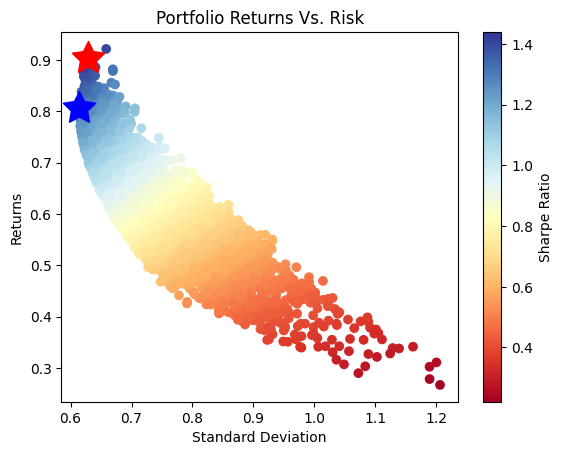

In [80]:
# This is so I can see the plot inside of my Jupyter Notebook.
%matplotlib inline

# Plot the data on a Scatter plot.
plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the Max Sharpe Ratio, using a `Red Star`.
plt.scatter(
    max_sharpe_ratio.iloc[1],
    max_sharpe_ratio.iloc[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

# Plot the Min Volatility, using a `Blue Star`.
plt.scatter(
    min_volatility.iloc[1],
    min_volatility.iloc[0],
    marker=(5, 1, 0),
    color='b',
    s=600
)

# Finally, show the plot.
plt.show()



### Notes: Portfolio Optimization
Monte Carlo Simulation:

Tries thousands of random weight combinations to find the best portfolio values.
Drawback: It is inefficient for finding optimal values.
Optimization with Mathematical Techniques:

More efficient compared to Monte Carlo.
Functions Used for Optimization:

get_metrics():
Returns portfolio metrics (e.g., returns, volatility, Sharpe ratio) for a given set of weights.
Acts like a "lookup" function.
neg_sharpe():
A minimization function used to minimize the negative Sharpe Ratio.
Scipy’s optimize function only supports minimization, so we minimize the negative Sharpe to maximize the Sharpe Ratio.
check_sum():
Ensures the sum of portfolio weights equals 100%.
Used as a constraint in optimization.

In [81]:
def get_metrics(weights: list) -> np.array:
    """
    ### Overview:
    ----
    With a given set of weights, return the portfolio returns,
    the portfolio volatility, and the portfolio sharpe ratio.

    ### Arguments:
    ----
    weights (list): An array of portfolio weights.

    ### Returns:
    ----
    (np.array): An array containg return value, a volatility value,
        and a sharpe ratio.
    """

    # Convert to a Numpy Array.
    weights = np.array(weights)

    # Calculate the returns, remember to annualize them (1008).
    ret = np.sum(log_return.mean() * weights) * 1008

    # Calculate the volatility, remember to annualize them (1008).
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 1008, weights))
    )

    # Calculate the Sharpe Ratio.
    sr = ret / vol

    return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[2] - 1

def grab_volatility(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    """Ensure the allocations of the "weights", sums to 1 (100%)

    ### Arguments:
    ----
    weights (list): The weights we want to check to see
        if they sum to 1.

    ### Returns:
    ----
    float: The different between 1 and the sum of the weights.
    """
    return np.sum(weights) - 1


### Notes: Running Portfolio Optimization
Scipy Optimization - minimize:

Used to find the optimal portfolio values.
Steps Before Running Optimization:

Bounds: Ensure each position is between 0% and 100% allocation.
Constraint: Ensure the total portfolio weights sum to 100% (fully allocated).
Initial Guess: Start with an equally distributed portfolio (e.g., 25% for 4 symbols).
Optimization Method:

Use SLSQP (Sequential Least Squares Programming).
Other methods exist but are out of scope for this tutorial.
Results:

fun Value: Optimized Sharpe Ratio.
x Value: Optimized weights.
Use the optimized weights to calculate portfolio metrics (returns, volatility, Sharpe ratio).

In [82]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(no_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = no_of_symbols * [1 / no_of_symbols]

# Perform the operation to minimize the risk.
optimized_sharpe = sci_plt.minimize(
    grab_negative_sharpe, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)


OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.8587271154759685
       x: [ 5.551e-17  5.551e-17  0.000e+00  1.000e+00]
     nit: 2
     jac: [ 6.534e-01  3.026e-01  5.868e-01 -0.000e+00]
    nfev: 10
    njev: 2
--------------------------------------------------------------------------------


In [83]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[5.55111512e-17 5.55111512e-17 0.00000000e+00 1.00000000e+00]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.19269071 1.36396106 0.14127288]
--------------------------------------------------------------------------------


In [84]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(no_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = no_of_symbols * [1 / no_of_symbols]

# Perform the operation to minimize the risk.
optimized_volatility = sci_plt.minimize(
    grab_volatility, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED VOLATILITY RATIO:')
print('-'*80)
print(optimized_volatility)
print('-'*80)


OPTIMIZED VOLATILITY RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.6134688890136468
       x: [ 3.670e-01  2.064e-01  4.266e-01  6.072e-18]
     nit: 7
     jac: [ 6.135e-01  6.135e-01  6.135e-01  8.547e-01]
    nfev: 35
    njev: 7
--------------------------------------------------------------------------------
